# Visual Analytics - Melanoma Classification

- Ziel: 
    - Visualisierungen und Analysen für meine Masterthesis erstellen
    - Matplotlib & Seaborn lernen
    - Plot-Funktionen erstellen, welche ich für weitere Projekte verwenden kann

- Zielgruppe:
    - Reviewer der Masterthesis

## Imports & Setup

In [2]:
# python modules
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
import shapefile as shp
import matplotlib as mlt
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

In [3]:
# custom modules
from utils.get_data import get_data
from utils.plots.histogramm import plot_hist
from utils.plots.barplot import show_bar_plot
from utils.convert_shapfile import read_shapefile
from utils.plots.image_histogramm import image_hist
from utils.plots.map import plot_map, plot_map_fill
from utils.plots.scatterplot import show_scatterplot
from utils.plots.show_image import show_single_image, show_images
from utils.image_helpers import get_means_and_stds, binarize_image
from utils.plots.correlation import show_corr_plot, show_regplot_plot

In [4]:
# automatic reload magic
%load_ext autoreload
%matplotlib inline
%autoreload 2

# setup sns
sns.set(style='whitegrid', palette='pastel', color_codes=True)
sns.mpl.rc('figure', figsize=(10,10))

IMG_DIR = "data/"

### Hautkrebs-Index Datensätze

In [5]:
cancer_index = pd.read_csv("data/Index-Hautkrebsanfaelligkeit.csv", sep=";")
cancer_index_so = pd.read_csv("data/Sozio-oekonomischer-Hautkrebsindex.csv", sep=";")

In [6]:
cancer_index.head(1)

Land     Region Hautkrebs-Inzidenz  Melanom Erkrankungen pro Jahr  \
0  Neuseeland  Australia                 10                           2473   

  UV-Intensität (ø) Hattyp (ø)  
0              6,88       4,75

In [7]:
cancer_index_so = cancer_index_so[['Land', 'Sterblichkeitsrate', 'Nationale Gesundheitsausgaben' ]]
cancer_index_so.head(1)

Land Sterblichkeitsrate Nationale Gesundheitsausgaben
0  Schweden             17.00%                          4,20

In [8]:
# combine both dataframes into one
df_cancer_index = cancer_index.merge(cancer_index_so, how="inner", on='Land')
df_cancer_index.head(3)

Land     Region Hautkrebs-Inzidenz  Melanom Erkrankungen pro Jahr  \
0  Neuseeland  Australia                 10                           2473   
1  Australien  Australia               9,67                          12265   
2     Schweiz     Europe               5,89                           2484   

  UV-Intensität (ø) Hattyp (ø) Sterblichkeitsrate  \
0              6,88       4,75             15.00%   
1              7,35       5,75             13.00%   
2               2,8       7,75             15.00%   

  Nationale Gesundheitsausgaben  
0                          5,19  
1                          4,98  
2                          2,81

In [9]:
df_cancer_index.shape

(57, 8)

### Erklärung der Daten

- Hautkrebs-Inzidenz: Anzahl neuer Hautkrebsfälle pro Jahr, gemessen an der Bevölkerung (skaliert von 1-10).
- Durchschnittliche UV-Intensität: Der Wert gibt an wie stark die UV-Strahlung im Jahresdurchschnitt in den einzelnen Ländern ist (skaliert von 1-10, größer = stärkere Strahlung).
- Sterblichkeitsrate: Durch schwarzen Hautkrebs verursachte Tode pro Jahr, geteilt durch die Anzahl der Neuerkrankungen vom schwarzen Hautkrebs pro Jahr. Basierend auf Daten des WHO Globocan Report.
- Durchschnittlicher Hauttyp: Basierend auf der Fitzpatrick-Skala, gibt dieser Wert an, wie stark Pigmentiert die Bevölkerung im Durchschnitt ist (skaliert von 1-10, größer = hellere Haut und somit anfälliger für Hautkrebs).
- Nationale Gesundheitsausgaben: Umso kleiner die Zahl, umso mehr geben die Länder für das Gesundheitssystem aus (skaliert von 1-10, kleiner = mehr).

Source: https://derma.plus/hautkrebs-index-2018 & https://derma.plus/globaler-hautkrebs-index

In [10]:
# Daten formatieren
df_cancer_index.rename({'Hattyp (ø)': 'Hauttyp (ø)'}, axis='columns', inplace=True)
df_cancer_index.replace({',': '.'}, regex=True, inplace = True)
df_cancer_index.replace({'%': ''}, regex=True, inplace = True)
df_cancer_index = df_cancer_index.astype({
    "Hautkrebs-Inzidenz": float, 
    "UV-Intensität (ø)": float,
    "Hauttyp (ø)": float,
    "Sterblichkeitsrate": float,
    "Nationale Gesundheitsausgaben": float
})

In [11]:
# 'Nationale Gesundheitsausgaben' neu skalieren, damit die größeren Werte mehr Ausgaben bedeuten
df_cancer_index['Nationale Gesundheitsausgaben'] = [abs(x - 10) for x in list(df_cancer_index['Nationale Gesundheitsausgaben'])]

### Kaggle Dataset

In [12]:
train_df = get_data("data/train.csv", "train", IMG_DIR)
train_df.head(3)

valid rows 20451


image_name  patient_id     sex  age_approx anatom_site_general_challenge  \
0  ISIC_2637011  IP_7279968    male        45.0                     head/neck   
1  ISIC_0015719  IP_3075186  female        45.0               upper extremity   
2  ISIC_0052212  IP_2842074  female        50.0               lower extremity   

  diagnosis benign_malignant  target                   image_path  
0   unknown           benign       0  data/train/ISIC_2637011.png  
1   unknown           benign       0  data/train/ISIC_0015719.png  
2     nevus           benign       0  data/train/ISIC_0052212.png

## Analyse der Bilder

### Wie lässt sich ein Bild analysieren?

- Ein Bild besteht aus mehreren Pixeln
- Je mehr Pixel ein Bild enhält, desto 
    - größer ist das Bild (da mehr Daten vorhanden sind)
    - schärfer ist das Bild (mehr Pixel ermöglichen bspw. ein schärferes abbilden von Kanten => Bild hat eine höhere Auflösung)
- Die Pixel in einem Bild werden in einem Raster abgebildet (ähnlich wie einer Tabelle, Anzahl Spalten = Breite, Anzahl Zeilen = Höhe)
- Ein schwarz weiß Bild ist ein 2-dimensionales Array 
    [
        [23,235,24,123,124,56],
        [23,235,24,123,124,56],
        [23,235,24,123,124,56]
    ]
- Ein Pixel-Wert kann eine Zahl zwischen 0 (schwarz) und 255 (weiß) sein
- Ein farbbild ist ein 3-dimensionales Array (Anstatt einem Wert zwischen 0 und 255 ist es jetzt ein Array, welches die Farbwerte für Rot, Grün und Blau enhält => RGB-Image)
    [
        [[123,12,42],[123,12,42],[123,12,42]]
    ]

In [13]:
# Speichern von zwei Beispielbildern
benign_image = train_df.iloc[0]
malignant_image = train_df.iloc[20438]

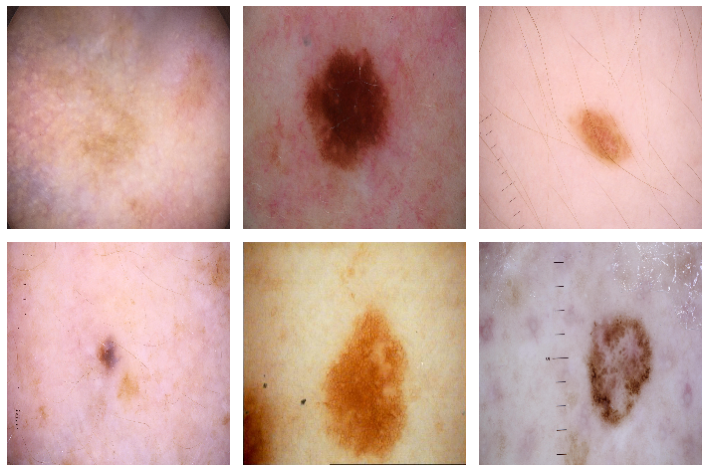

In [14]:
# Darstellung von neun zufällig ausgewählten Bildern aus dem Datensatz
imgs = list(train_df.sample(9).image_path)
show_images(imgs, 3, 2)

### Pixel Verteilungen

- Bilder können normalisiert werden (damit 1 der größte Wert ist und nicht mehr 255) ohne Informationen zu verlieren
- Von jedem Bild kann der Durchschnitt der Pixel berechnet werden. Dieser gibt an, wie viele Pixel mit welcher Intensität (Wert zwischen 0 und 255) vorhanden sind.
- Der Durchschnitt sagt uns unter anderem, ob die Bilder eher heller oder dunkler sind.
- Eine geringe Standardabweichung bedeutet, dass die Pixelintensitäten näher am Mittelwert liegen und eine hohe Varianz bedeutet, dass die Pixelintensitäten weit vom Mittelwert entfernt sind. Bspw. ist der Kontrast hoch für Bilder mit hohen Standardabweichungswerten.
- Diese beiden Informationen können uns Aufschluss darüber geben, ob wir die Bilder besonders verarbeiten müssen oder überhaupt verwenden können.

In [15]:
means, stds = get_means_and_stds(train_df.head(5000))

100%|██████████| 5000/5000 [04:31<00:00, 18.42it/s]


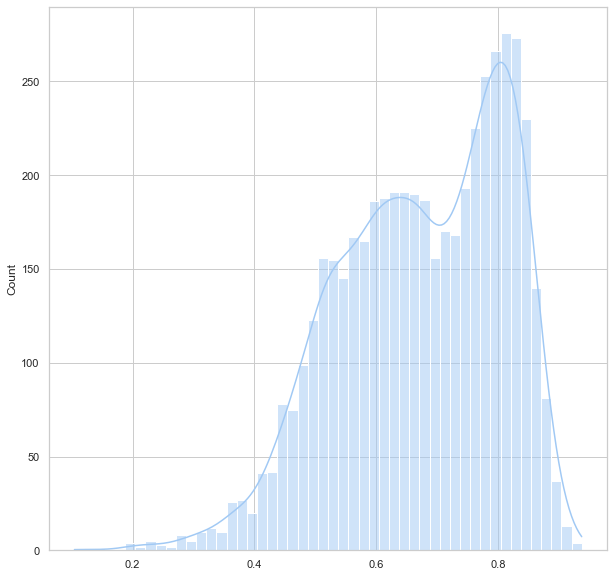

In [16]:
plot_hist(means, 50)

Anhand der Verteilung der Means können wir sehen, dass wir eher hellere Bildern haben.

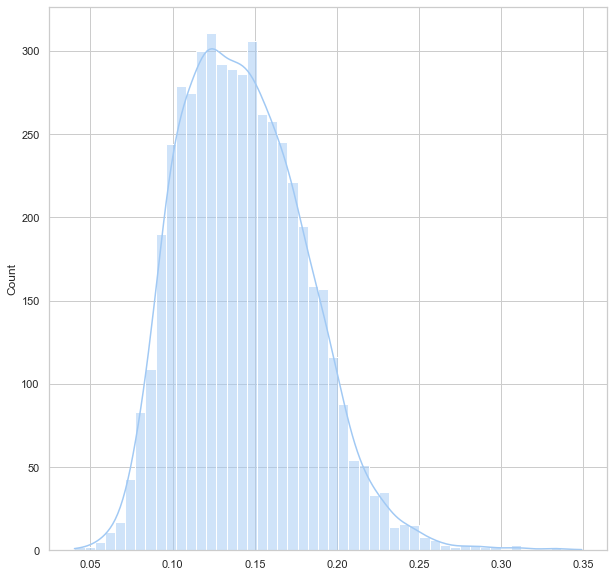

In [17]:
plot_hist(stds, 50)

Die Varianz der Bilder liegt eher im unterem Bereich. Dies lässt vermuten, dass die Bilder eher einheitlich sind und über wenig Kontrast verfügen.

### Unterscheiden sich die Means und Stds bei Fällen von Hautkrebs im Vergleich zu harmlosen Läsionen?

In [18]:
global_mean = np.mean(means)
global_std = np.mean(stds)

malignant = train_df['benign_malignant']=='malignant'
benign = train_df['benign_malignant']=='benign'

malignant_df = train_df[malignant]
malignant_means, malignant_stds = get_means_and_stds(malignant_df.head(2500))

benign_df = train_df[benign]
benign_means, benign_stds = get_means_and_stds(benign_df.head(2500))

print(" ")
print(" ")

print("global mean:", global_mean)
print("global std:", global_std)

print(" ")

global_malignant_mean = np.mean(malignant_means)
print("global malignant mean:", global_malignant_mean)

global_benign_mean = np.mean(benign_means)
print("global benign mean:", global_benign_mean)

100%|██████████| 2500/2500 [00:11<00:00, 224.93it/s] 
 
global mean: 0.674429
global std: 0.14313841
 
global malignant mean: 0.5686471
global benign mean: 0.67643493



### Verteilung der durchschnittlichen Pixelintensitäten zwischen Begign und Malignant 

<AxesSubplot:xlabel='value', ylabel='kind'>

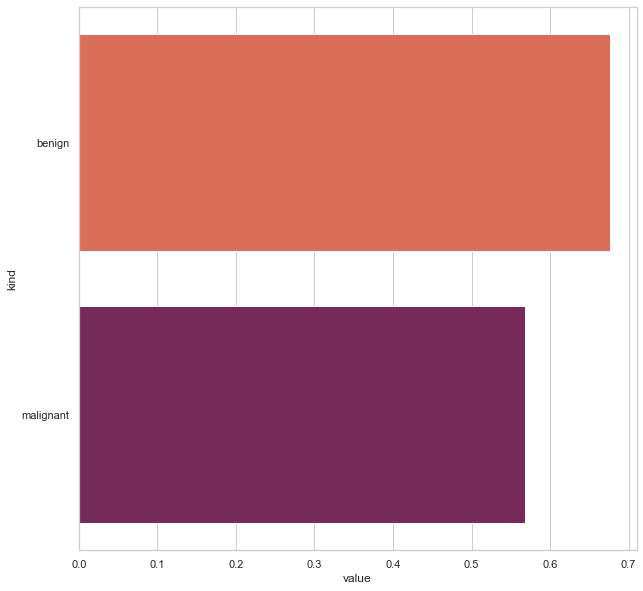

In [19]:
data = [['benign', global_benign_mean], ['malignant', global_malignant_mean]] 
df_means = pd.DataFrame(data, columns = ['kind', 'value']) 
sns.barplot(data=df_means, y="kind", x="value", orient = "h", palette="rocket_r")

Wir können sehen, dass im Durchschnitt die bösartigen Fälle eine niedrigere Pixelintensität haben. Da wir schwarzen Hautkrebs erkennen wollen könnte dies hilfreich bei der Klassifizierung sein.

### Verteilung der Varianzen zwischen Begign und Malignant 

<AxesSubplot:xlabel='value', ylabel='kind'>

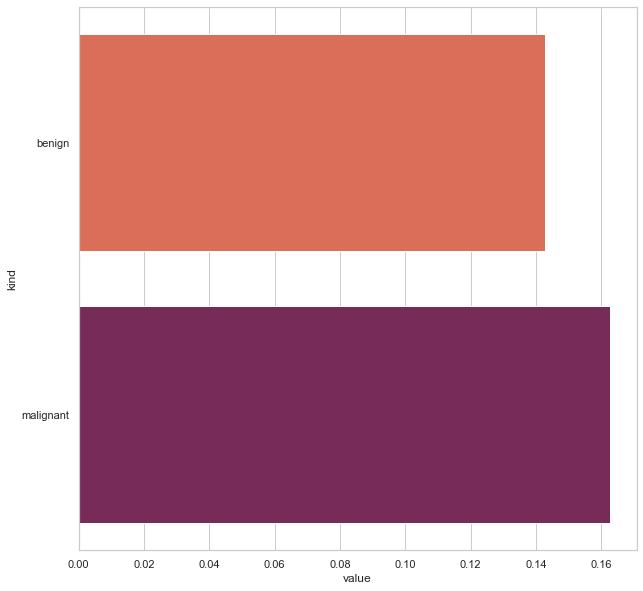

In [20]:
data = [['benign', np.mean(benign_stds)], ['malignant', np.mean(malignant_stds)]] 
df_means = pd.DataFrame(data, columns = ['kind', 'value']) 
sns.barplot(data=df_means, y="kind", x="value", orient = "h", palette="rocket_r")

Anhand der Verteilung der Varianz lässt sich erkennen, dass bösartige Fälle eine etwas höhere Standardabweichnung haben. Dies bedeutet, dass die Pixelintensität stärker vom Mittelwert abweicht. Auch dies macht Sinn, da schwarzer Hautkrebs vor allem bei hellhäutigen Menschen einen hohen Kontrast erzeugt.

### Bildanalyse Benign

image_name                                      ISIC_2637011
patient_id                                        IP_7279968
sex                                                     male
age_approx                                              45.0
anatom_site_general_challenge                      head/neck
diagnosis                                            unknown
benign_malignant                                      benign
target                                                     0
image_path                       data/train/ISIC_2637011.png
Name: 0, dtype: object
 
Image dimensions:  (224, 224)
Maximum pixel value : 1.0 ; Minimum pixel value:0.0
Mean value of the pixels : 0.7 ; Standard deviation : 0.2


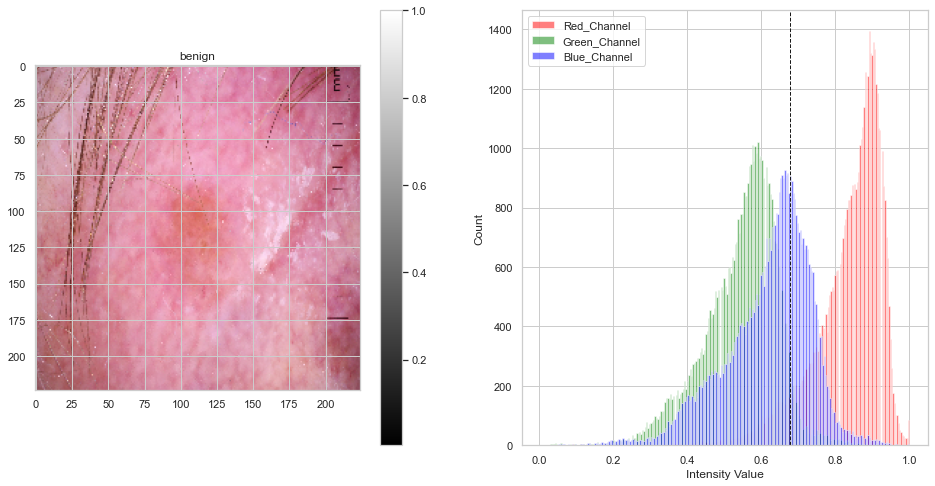

In [21]:
print(benign_image)
print(" ")
image_hist(benign_image.image_path, benign_image.benign_malignant, global_benign_mean)

### Bildanalyse Malignant

image_name                                      ISIC_6220625
patient_id                                        IP_7373371
sex                                                   female
age_approx                                              55.0
anatom_site_general_challenge                upper extremity
diagnosis                                           melanoma
benign_malignant                                   malignant
target                                                     1
image_path                       data/train/ISIC_6220625.png
Name: 20438, dtype: object
 
Image dimensions:  (224, 224)
Maximum pixel value : 1.0 ; Minimum pixel value:0.1
Mean value of the pixels : 0.6 ; Standard deviation : 0.1


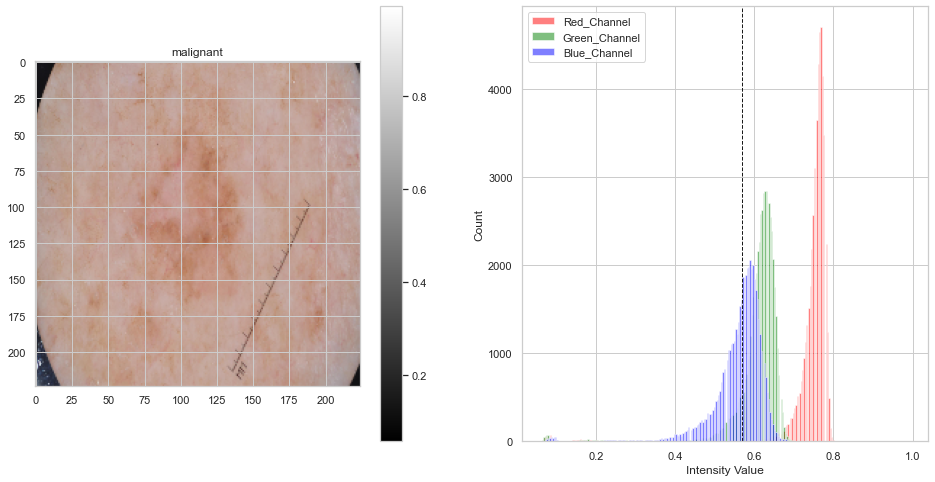

In [22]:
print(malignant_image)
print(" ")
image_hist(malignant_image.image_path, malignant_image.benign_malignant, global_malignant_mean)

Bei dem Malignant Case können wir sehen, dass das Bild nicht über eine so große Farbtiefe verfügt wie der Benign Case (die Verteilungen sind flacher). Der Durchschnitt der Pixelverteilungen sowie auch die Standardabweichung sind beim Malignant Case allerdings geringer als beim Benign Case. 

### Bildanalyse Malignant + Benign Mean

image_name                                      ISIC_6220625
patient_id                                        IP_7373371
sex                                                   female
age_approx                                              55.0
anatom_site_general_challenge                upper extremity
diagnosis                                           melanoma
benign_malignant                                   malignant
target                                                     1
image_path                       data/train/ISIC_6220625.png
Name: 20438, dtype: object
 
Image dimensions:  (224, 224)
Maximum pixel value : 1.0 ; Minimum pixel value:0.1
Mean value of the pixels : 0.6 ; Standard deviation : 0.1


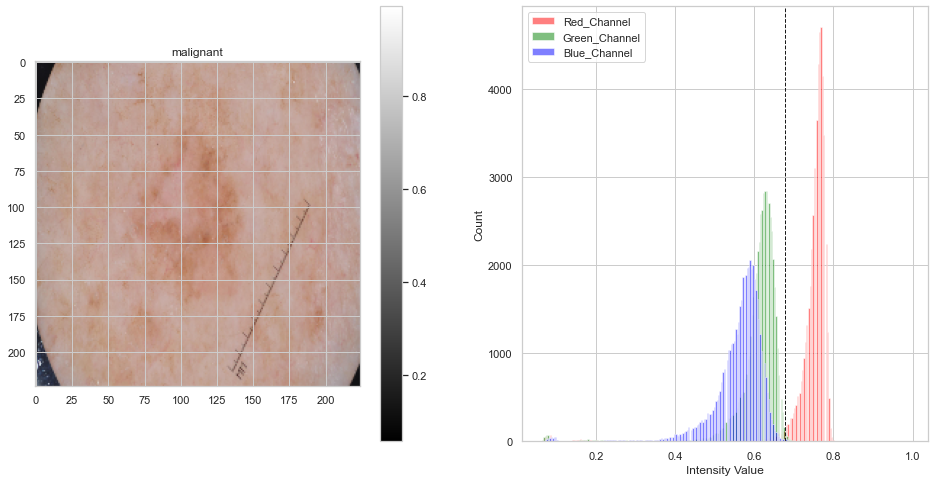

In [23]:
print(malignant_image)
print(" ")
image_hist(malignant_image.image_path, malignant_image.benign_malignant, global_benign_mean)

Anhand der Bilder von Melanomen und gutartigen Läsionen kann man erkennen wie schwierig es ist die richtige Diagnose zu stellen und auch, dass Durchschnitte und Varianzen nicht wirklich etwas beitragen können.

## Analyse Hautkrebsindex

### Welches Land hat die meisten Hautkrebserkrankungen pro Jahr?

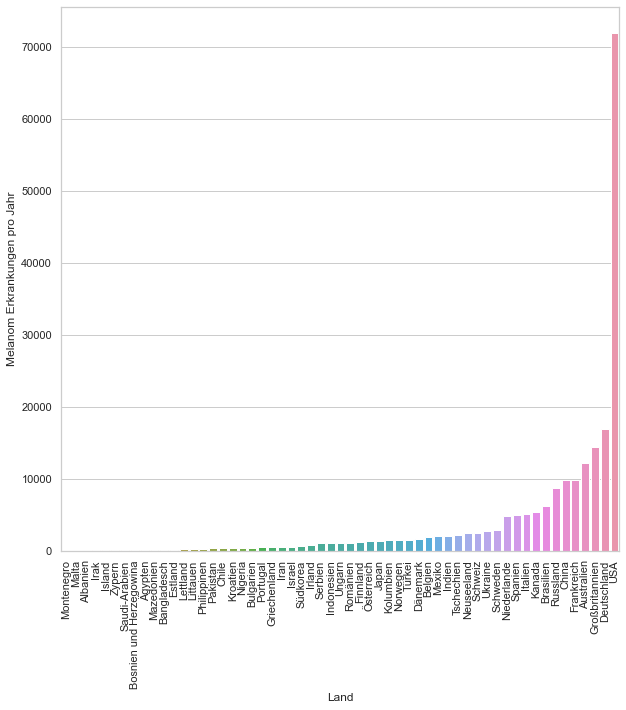

In [24]:
df_cancer_index.sort_values(by=['Melanom Erkrankungen pro Jahr'], inplace=True)
show_bar_plot(df_cancer_index, 'Land', 'Melanom Erkrankungen pro Jahr')

USA hat absolut gesehen die meisten Hautkrebs-Diagnosen pro Jahr.

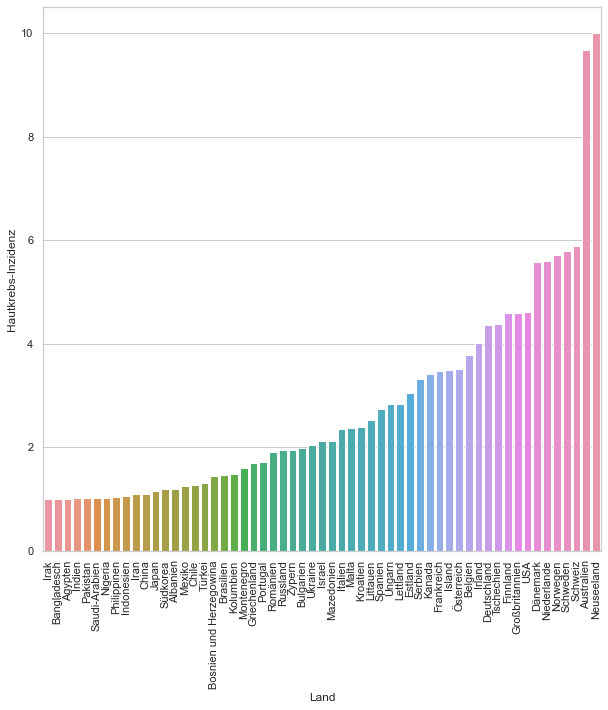

In [25]:
df_cancer_index.sort_values(by=['Hautkrebs-Inzidenz'], inplace=True)
show_bar_plot(df_cancer_index, 'Land', 'Hautkrebs-Inzidenz')

Betrachtet man allerding die Anzahl der Hautkrebs-Diagnosen in Abhängigkeit zur Bevölkerungsgröße sind Neuseeland und Australien die Länder mit der höchsten Quote an Hautkrebserkrankungen.

### Correlation Plot

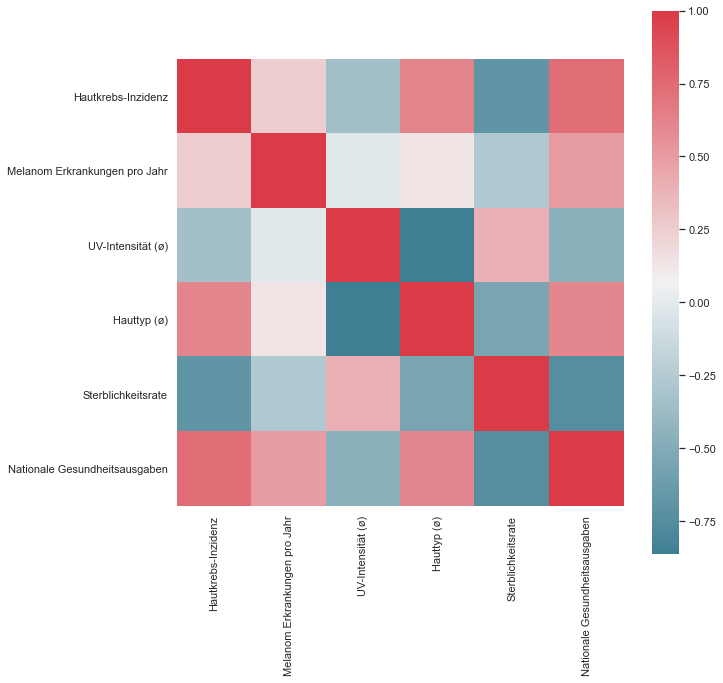

In [26]:
show_corr_plot(df_cancer_index)

- UV-Intensität und Hautfarbe haben eine negative Korrelation (nimmt die UV-Intensität ab wird der Hauttyp heller)
- Ebenso haben die Sterblichkeitsrate und die Nationalen Gesundheitsausgaben eine negative Korrelation (weniger Ausgaben -> höhere Sterblichkeit)
- Die Hautkrebs-Inzidenz und dere Hauttyp scheinen eine postive Korrelation zu haben

### Ist UV-Intensität ein Risikofaktor für Melanomerkrankungen?

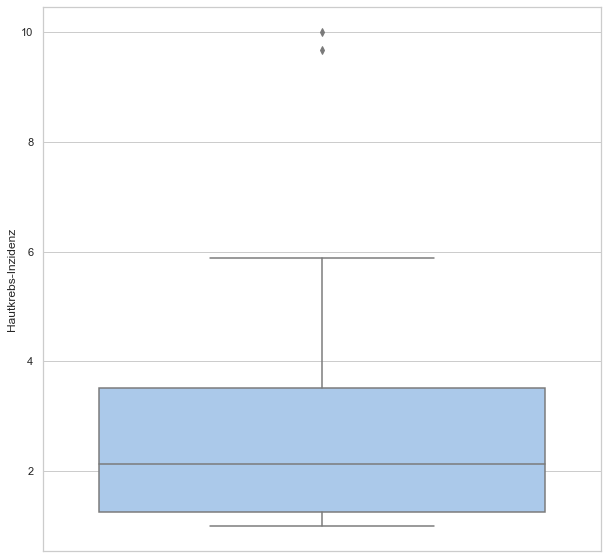

In [27]:
sns.boxplot(y=df_cancer_index["Hautkrebs-Inzidenz"])
plt.show()

Wir sehen sofort die zwei Ausreißer Neuseeland und Australien. Der Großteil aller Länder hat eine Inzidenz zwischen 1 und unter 4. Der Median liegt bei knapp über zwei.

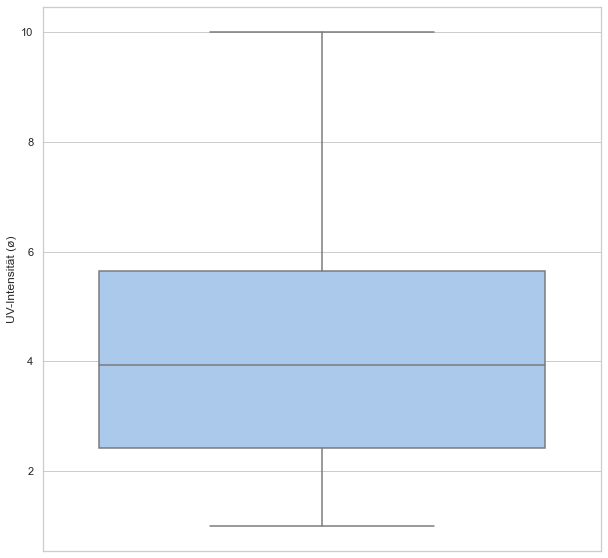

In [28]:
sns.boxplot(y=df_cancer_index["UV-Intensität (ø)"])
plt.show()

Die UV-Intensität liegt zwischen 1 und 10, der Median ist knapp unter 4. Die Mehrheit (50%) liegt zwischen ca. 2.2 und 5.9.

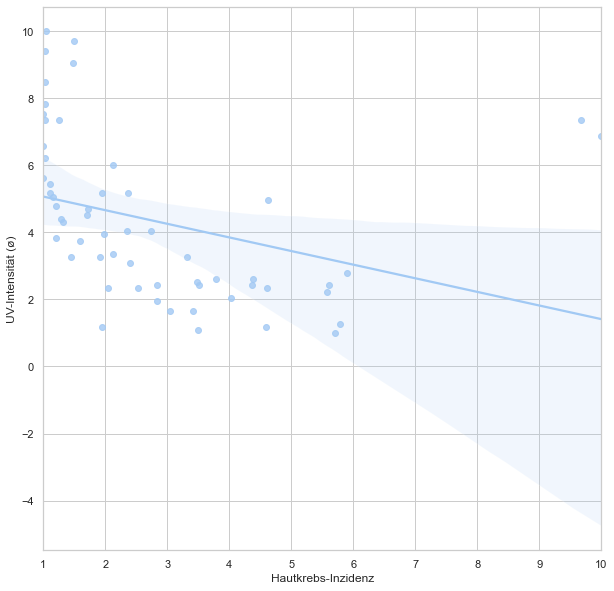

In [29]:
show_regplot_plot(df_cancer_index, 'Hautkrebs-Inzidenz', 'UV-Intensität (ø)')

Es scheint so zu sein, als würde die UV-Intensität kein Risikofaktor sein, obwohl UV-Strahlung in mehreren Studien als Risikofaktor gennant wird. Dies hat mehrere Gründe:
- UV-Intensität != UV-Strahlung (bzw. nicht Zeit in welcher man UV-Strahlung ausgesetzt ist. UV-Strahlung bekommt man auch in Bräunungskabinen)
- UV-Intensität ist nicht einziger Faktor

### Wie verändert sich der Hauttyp in Zusammenhang mit der UV-Intensität?

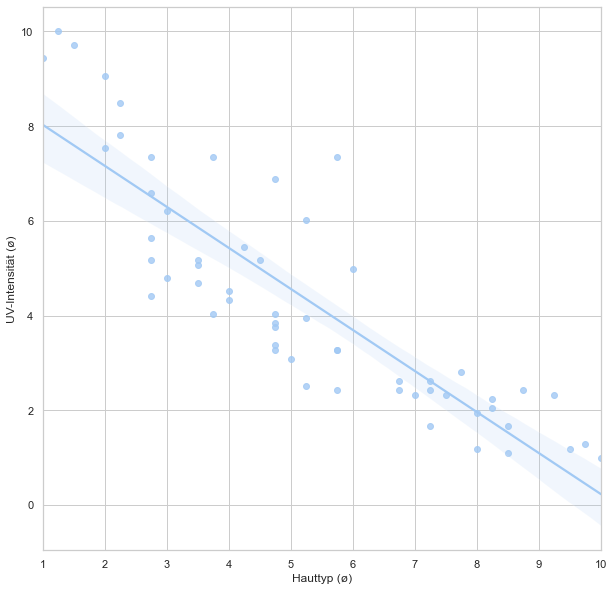

In [30]:
show_regplot_plot(df_cancer_index, 'Hauttyp (ø)', 'UV-Intensität (ø)')

Wir können sehen, dass die Hauttypen heller werden (Zahlen werden größer), je mehr die UV-Intensität abnimmt.

### Wie wirkt sich der Hauttyp auf die Hautkrebs-Inzidenz aus?

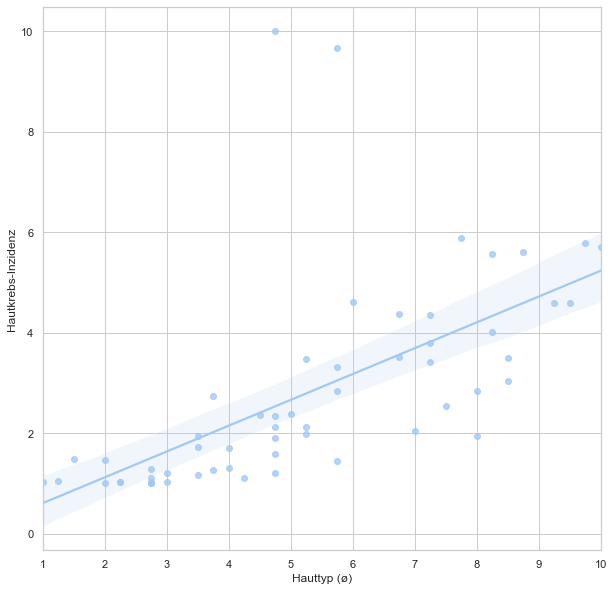

In [31]:
show_regplot_plot(df_cancer_index, 'Hauttyp (ø)', 'Hautkrebs-Inzidenz')

Anhand diesen Graphen können wir sehen, dass Länder mit helleren Hauttypen eine höhere Hautkrebs-Inzidenz haben.

### Wirken sich die Gesundheitsausgaben auf die Sterblichkeitsrate aus?

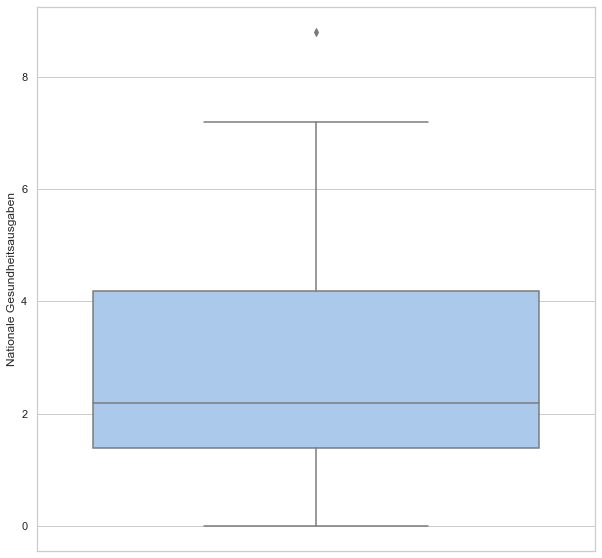

In [32]:
sns.boxplot(y=df_cancer_index["Nationale Gesundheitsausgaben"])
plt.show()

Der Median der Gesundheitsausgaben aller Länder liegt knapp über 2, 50% aller Werte liegen bei ca. 1.7 und knapp über 4. Es gibt einen Ausreißer mit Gesundheitsausgaben bei fast 9.

In [33]:
df_cancer_index.sort_values(by=['Nationale Gesundheitsausgaben'], ascending = False).head(3)

Land         Region  Hautkrebs-Inzidenz  Melanom Erkrankungen pro Jahr  \
7       USA  North America                4.62                          72000   
2   Schweiz         Europe                5.89                           2484   
4  Norwegen         Europe                5.71                           1506   

   UV-Intensität (ø)  Hauttyp (ø)  Sterblichkeitsrate  \
7               4.98         6.00                14.0   
2               2.80         7.75                15.0   
4               1.00        10.00                22.0   

   Nationale Gesundheitsausgaben  
7                           8.80  
2                           7.19  
4                           6.56

In [34]:
df_cancer_index.sort_values(by=['Nationale Gesundheitsausgaben'], ascending = False).tail(3)

Land       Region  Hautkrebs-Inzidenz  \
56  Bangladesch         Asia                1.00   
48   Indonesien         Asia                1.05   
52     Pakistan  Middle East                1.02   

    Melanom Erkrankungen pro Jahr  UV-Intensität (ø)  Hauttyp (ø)  \
56                            153               7.54         2.00   
48                           1069              10.00         1.25   
52                            325               6.21         3.00   

    Sterblichkeitsrate  Nationale Gesundheitsausgaben  
56                62.0                           0.06  
48                51.0                           0.04  
52                63.0                           0.00

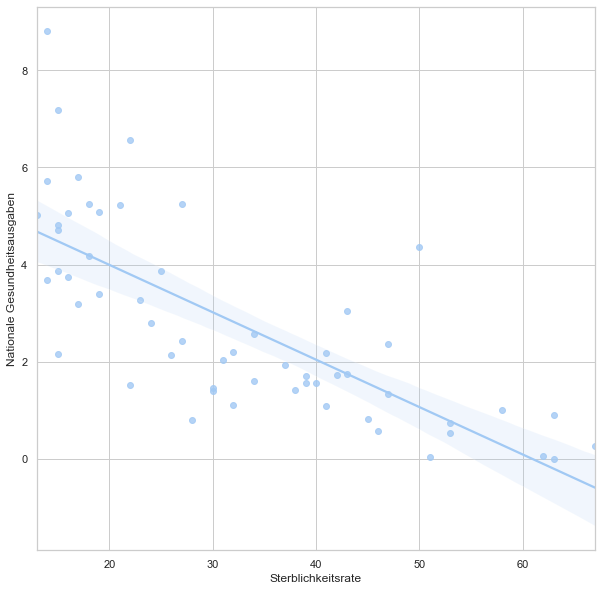

In [35]:
show_regplot_plot(df_cancer_index, 'Sterblichkeitsrate', 'Nationale Gesundheitsausgaben')

### Welches Land hat die höchste Sterblichkeitsrate?

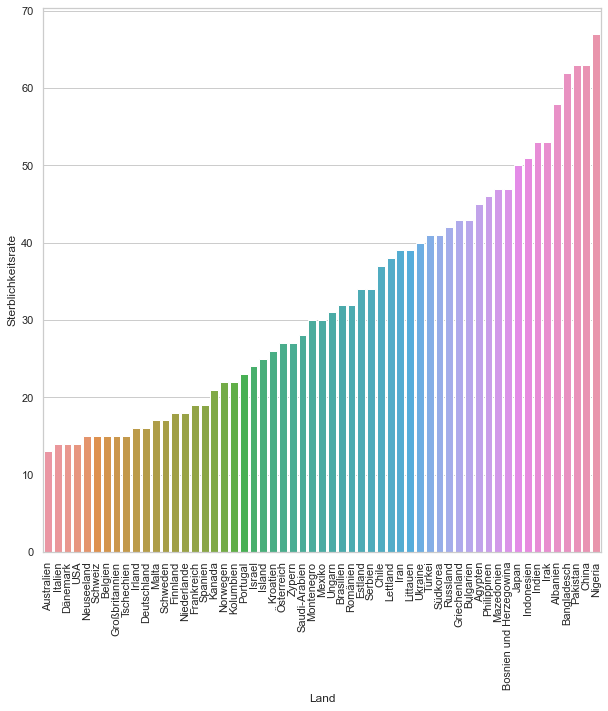

In [36]:
df_cancer_index.sort_values(by=['Sterblichkeitsrate'], inplace=True)
show_bar_plot(df_cancer_index, 'Land', 'Sterblichkeitsrate')